#### Загрузка, обработка данных

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import pingouin as pg
import datetime

In [2]:
def date_converter(x):
    for fmt in ('%Y-%m-%d %H:%M:%S.%f', '%Y-%m-%d %H:%M:%S', '%Y-%m-%d'):
        try:
            return datetime.datetime.strptime(x, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')

In [3]:
df_segment = pd.read_csv('/Users/apple/Desktop/ААА/биг кейс/services_verification_experiment_segment.csv')
df_payment = pd.read_csv('/Users/apple/Desktop/ААА/биг кейс/user_payments_info.csv')
df_discount = pd.read_csv('/Users/apple/Desktop/ААА/биг кейс/services_verification_discounts.csv')
df_item = pd.read_csv('/Users/apple/Desktop/ААА/биг кейс/user_item_info.csv')

In [5]:
df_temp = df_discount.merge(df_item[['item_id', 'item_vertical']], on = 'item_id', how = 'left')

In [8]:
df_temp['item_vertical'].unique()

array([ 1.,  3., nan,  6.,  2.,  4.,  5.])

In [9]:
df_payment=df_payment.drop('Unnamed: 0', axis=1)
df_payment['event_time'] = df_payment.event_time.apply(date_converter)
df_segment=df_segment.drop('Unnamed: 0', axis=1)
df_discount['discount_day'] = df_discount.discount_day.apply(date_converter)

In [10]:
df_pay_seg = df_payment.merge(df_segment, on='user_id')
df_pay_info = df_pay_seg.merge(df_discount, on='item_id', how='left')
df_pay_full = df_pay_info.drop(['user_id_y', 'Unnamed: 0', 'experiment'], axis=1)

df_pay_full=df_pay_full.fillna(0)

In [11]:
df_pay_full = df_pay_full.merge(df_item[['item_id', 'item_vertical']], on = 'item_id', how='left')

In [12]:
df_pay_full =df_pay_full.fillna(0)

In [13]:
df_pay_full['revenue_pred'] = df_pay_full[df_pay_full['event_time']< date_converter('2021-09-15 00:00:00')]['amount_net']
df_pay_full['revenue_test'] = df_pay_full[df_pay_full['event_time']>= date_converter('2021-09-15 00:00:00')]['amount_net']

In [14]:
df_pay_full['event_time'].min()

Timestamp('2021-06-01 00:00:02.357927')

In [15]:
df_pay_full['event_time'].max()

Timestamp('2021-12-01 23:59:33')

In [16]:
df_pay_full = df_pay_full.fillna(0)

In [325]:
df_discount

,Unnamed: 0,user_id,item_id,discount_day,experiment
0,0,49000737,11352751363,2021-10-01,1_verification_test
1,1,4255271,78048500109,2021-10-10,1_verification_test
2,2,111000153,101676750179,2021-10-02,1_verification_test
3,3,110750728,162344000369,2021-10-14,1_verification_test
4,4,143655000006,252307750608,2021-10-09,1_verification_test
...,...,...,...,...,...
29958,29958,65500899,1129535751173,2021-09-25,1_verification_test
29959,29959,830210750056,1129550000127,2021-09-30,1_verification_test
29960,29960,368182337,1129612500421,2021-09-30,1_verification_test
29961,29961,399483500082,1130392750186,2021-09-27,1_verification_test


In [327]:
df_discount[df_discount.duplicated(subset=['user_id'],keep=False)]

,Unnamed: 0,user_id,item_id,discount_day,experiment
0,0,49000737,11352751363,2021-10-01,1_verification_test
1,1,4255271,78048500109,2021-10-10,1_verification_test
4,4,143655000006,252307750608,2021-10-09,1_verification_test
23,23,3563000104,480168500126,2021-10-05,1_verification_test
27,27,365109750151,537386251639,2021-10-06,1_verification_test
...,...,...,...,...,...
29957,29957,383716649,1129417500552,2021-09-25,1_verification_test
29958,29958,65500899,1129535751173,2021-09-25,1_verification_test
29960,29960,368182337,1129612500421,2021-09-30,1_verification_test
29961,29961,399483500082,1130392750186,2021-09-27,1_verification_test


In [ ]:
df_discount.groupby(['user_id'])['discount_day']

In [328]:
df_discount[df_discount.user_id == 49000737]

,Unnamed: 0,user_id,item_id,discount_day,experiment
0,0,49000737,11352751363,2021-10-01,1_verification_test
6455,6455,49000737,125326751194,2021-10-01,1_verification_test
14096,14096,49000737,468541250039,2021-10-01,1_verification_test
17047,17047,49000737,939891000081,2021-10-01,1_verification_test
29011,29011,49000737,57002153,2021-10-01,1_verification_test


In [326]:
df_discount['user_id'].nunique()

22658

In [41]:
df_verific = df_segment.merge(df_discount, on='user_id', how='left')
df_verific = df_verific.drop(['Unnamed: 0', 'experiment'], axis=1).fillna(0)
df_verific['verified'] = df_verific['item_id'] >0

In [434]:
def descr(d, groups, col):
    for a in groups:
        print(a)
        t = d[d.experiment_group==a][col]
        print(f'среднее = {t.mean()}, СКО = {t.std()}, медиана = {t.median()}, 75% квантиль = {t.quantile(0.75)}, 95% квантиль = {t.quantile(0.95)}, 99% квантиль = {t.quantile(0.99)}, 99.9% квантиль = {t.quantile(0.999)}, кол-во = {t.count()}')

In [302]:
def ttest(data, test, control, col):
    print(f'Среднее {test} = ', data[data['experiment_group']==test][col].mean())
    print(f'Среднее {control} = ', data[data['experiment_group']==control][col].mean())
    print(stats.ttest_ind(data[data['experiment_group']==test][col],data[data['experiment_group']==control][col]))

In [303]:
def ttest_groups(d, groups, col):
    for i in range(3):
        for j in range(i+1, 3):
            ttest(d, groups[i], groups[j], col)

In [304]:
def add_cuped(d, groups, test, pred):
    for a in groups:
        t = d[d.experiment_group == a]
        teta = np.cov(t[test], t[pred], ddof = 1)[1,0]/np.var(t[pred])
        m = np.mean(t[pred])
        cuped = t[test] - teta*(t[pred] - m)
        d = d.join(cuped.to_frame(name=f'{a}_cuped'), how='left')
    d = d.fillna(0)
    d['cuped'] = d['no_discount_cuped'] + d['30_discount_cuped'] + d['60_discount_cuped']
    return d

#### **Постановка задачи**

Данные:
- прошел/нет верификацию; на какое объявление использовал скидку
- инфо об объявлениях (регион, вертикаль, дата создания)
- инфо о продавцах (юр/физ лицо, дата регистрации, покупки)

Идея: Продавцы будут охотнее верифицировать свой аккаунт, если выдавать им скидку на услуги Авито за прохождение верификации.

Экспериментальные группы: 
- получили сообщение о том, что если пройдут верификацию, это будут видеть покупатели
- получили то же сообщение + скидка 30% на услуги продвижения (3 тип услуг, 1 вертикаль)
- получили то же сообщение + скидка 60% на услуги продвижения (3 тип услуг, 1 вертикаль)

Вопросы:

Скидка стимулирует верификацию аккаунта?
- метрика: % верификаций
- H0: % верификаций в группе со скидкой = % верификаций в группе без скидки

В группах, где больше скидка, больше покупок? Какой размер скидки оптимален?
- метрики: число покупок на пользователя, ARPU
- H0: покупки/ARPU в группе со скидкой = покупки/ARPU в группе без скидки

#### **Предварительный анализ данных** 

На предпериоде, для метрик ARPPU и число покупок на пользователя

##### **ARPU**

In [ ]:
revenue_users = df_pay_full.groupby(['experiment_group', 'user_id_x'])['revenue_pred'].sum().reset_index()
groups = ['no_discount', '30_discount', '60_discount']

In [305]:
descr(revenue_users, groups, 'revenue_pred')

60_discount
среднее = 419.86570929217515, СКО = 3860.0371332452282, медиана = 76.8461538461538, 99% квантиль = 4590.762515384598, 99.9% квантиль = 39427.8594653953
30_discount
среднее = 401.15674508092866, СКО = 3198.534223171417, медиана = 76.3846153846154, 99% квантиль = 4444.66638461538, 99.9% квантиль = 36135.51246153976
no_discount
среднее = 434.3674498982861, СКО = 6826.732826363259, медиана = 76.69230769230771, 99% квантиль = 4713.658346153846, 99.9% квантиль = 37962.157253077756


- Медианы совпадают
- Средние отличаются, макисмальное в группе no_discount
- В группе no_discount СКО больше в два раза

Все это говорит о том, что в среднем группы не различаются, но пользователи с большими ARPU распеределены не равномерно - их больше в no_discount(пользователей )

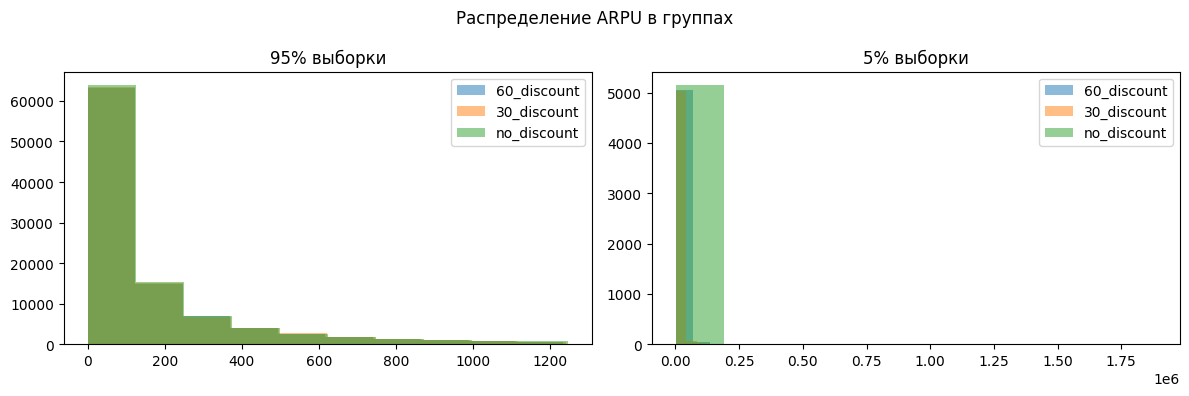

In [312]:
f, ax = plt.subplots(1,2, figsize=(12,4))
for a in groups:
    t = revenue_users[revenue_users.experiment_group==a]['revenue_pred']
    ax[0].hist(t[t.values<=t.quantile(0.95)], alpha = 0.5, label = a)
    ax[1].hist(t[t.values>t.quantile(0.95)], alpha = 0.5, label = a)
ax[0].set_title('95% выборки')
ax[1].set_title('5% выборки')
ax[0].legend()
ax[1].legend()
f.suptitle('Распределение ARPU в группах')
f.set_tight_layout(True)
plt.show()

- На графике слева видим, что 95% выборок распределены примерно одинаково
- График справа подтверждает предположение о наличии выбросов в группе no_diacount

In [20]:
# t-test на равенство средних

for i in range(3):
    for j in range(i+1, 3):
        print(groups[i], groups[j])
        print(stats.ttest_ind(revenue_users[revenue_users['experiment_group']==groups[i]]['revenue_pred'],revenue_users[revenue_users['experiment_group']==groups[j]]['revenue_pred']))

no_discount 30_discount
Ttest_indResult(statistic=1.4110619999187177, pvalue=0.15822784503710177)
no_discount 60_discount
Ttest_indResult(statistic=0.5920084139050339, pvalue=0.5538456051456526)
30_discount 60_discount
Ttest_indResult(statistic=-1.193939775536545, pvalue=0.23250291090867192)


t-test показал, что средние различаются не значимо

In [22]:
for i in range(3):
    for j in range(i+1, 3):
        _, p = stats.kstest(revenue_users[revenue_users.experiment_group==groups[i]]['revenue_pred'],
                     revenue_users[revenue_users.experiment_group==groups[j]]['revenue_pred'])
        print(f'H0: {groups[i]} = {groups[j]}, p-value = {p}')

H0: no_discount = 30_discount, p-value = 0.9503248543607636
H0: no_discount = 60_discount, p-value = 0.5256025985574543
H0: 30_discount = 60_discount, p-value = 0.31415908315859564


Критерий Колмагорова-Смирнова не показал, что выборки экспериментальных групп семплированы из разных распределений. Но СКО контрольной группы отличается от тестовых почти в 2 раза. Поэтому при интерпретации будем использовать CUPED и смотреть отдельно для 95% и 5% распределения.

Далее также проанализируем метрику число покупок на пользователя

##### **Покупки на пользователя**

In [314]:
df_pay_full['buy_pred'] = df_pay_full.revenue_pred > 0
df_pay_full['buy_test'] = df_pay_full.revenue_test > 0

buys_users_test = df_pay_full.groupby(['experiment_group', 'user_id_x'])['buy_test'].sum().reset_index()
buys_users_pred = df_pay_full.groupby(['experiment_group', 'user_id_x'])['buy_pred'].sum().reset_index()

In [315]:
descr(buys_users_pred, groups, 'buy_pred')

60_discount
среднее = 14.52172764625318, СКО = 199.74293614506047, медиана = 2.0, 99% квантиль = 144.0, 99.9% квантиль = 1770.124000000069
30_discount
среднее = 13.305717995528697, СКО = 156.77045402656805, медиана = 2.0, 99% квантиль = 136.0, 99.9% квантиль = 1575.5300000002026
no_discount
среднее = 15.254705848213423, СКО = 375.5307782412295, медиана = 2.0, 99% квантиль = 144.0, 99.9% квантиль = 1690.7130000001634


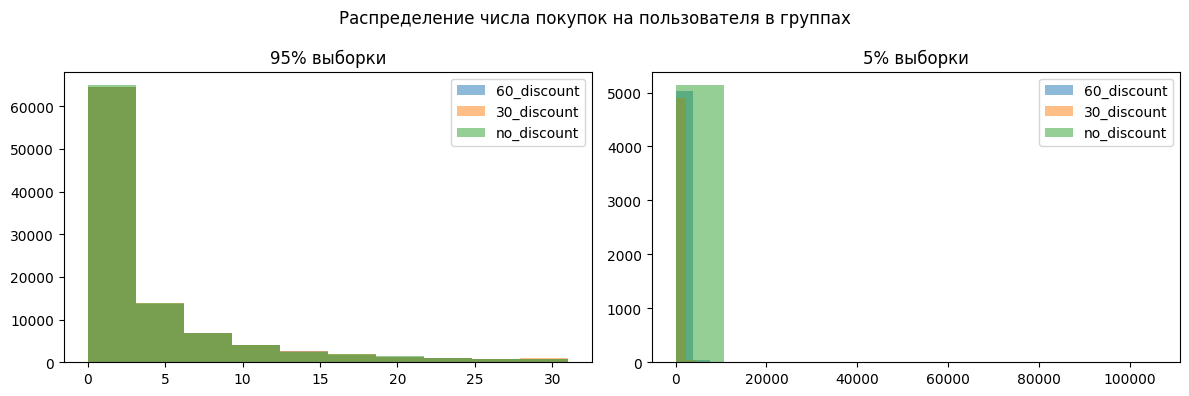

In [317]:
f, ax = plt.subplots(1,2, figsize=(12, 4))
for a in groups:
    t = buys_users_pred[buys_users_pred.experiment_group==a]['buy_pred']
    ax[0].hist(t[t.values<=t.quantile(0.95)], alpha = 0.5, label = a)
    ax[1].hist(t[t.values>t.quantile(0.95)], alpha = 0.5, label = a)
ax[0].set_title('95% выборки')
ax[1].set_title('5% выборки')
ax[0].legend()
ax[1].legend()
f.suptitle('Распределение числа покупок на пользователя в группах')
f.set_tight_layout(True)
plt.show()


In [26]:
# t-test на равенство средних

for i in range(3):
    for j in range(i+1, 3):
        print(groups[i], groups[j])
        print(stats.ttest_ind(buys_users_pred[buys_users_pred['experiment_group']==groups[i]]['buy_pred'],buys_users_pred[buys_users_pred['experiment_group']==groups[j]]['buy_pred']))

no_discount 30_discount
Ttest_indResult(statistic=1.533878200472596, pvalue=0.12506115701251883)
no_discount 60_discount
Ttest_indResult(statistic=0.5516376191027822, pvalue=0.5811972564777943)
30_discount 60_discount
Ttest_indResult(statistic=-1.53210630681474, pvalue=0.1254977494358592)


In [27]:
for i in range(3):
    for j in range(i+1, 3):
        _, p = stats.kstest(buys_users_pred[buys_users_pred.experiment_group==groups[i]]['buy_pred'],
                     buys_users_pred[buys_users_pred.experiment_group==groups[j]]['buy_pred'])
        print(f'H0: {groups[i]} = {groups[j]}, p-value = {p}')

H0: no_discount = 30_discount, p-value = 0.9799141761239896
H0: no_discount = 60_discount, p-value = 0.8175941518269176
H0: 30_discount = 60_discount, p-value = 0.6834348141585147


Наблюдаем то же, что и для ARPU:
- средние в группах не различаются
- СКО группы no_discount в 2 раза превышает СКО других групп из-за того, что no_dicount содержит больше выбросов

#### **Интерпретация результатов**

##### **Гипотеза1: Чем больше скидка, тем больше % верификаций?**

In [341]:
n = df_discount['user_id'].nunique()
verified_users = pd.DataFrame({'user_id':df_discount['user_id'].unique(), 'verified': np.ones((n,))})

In [342]:
df_verified = df_segment.merge(verified_users, on='user_id', how = 'left')

In [345]:
df_verified = df_verified.fillna(0)

In [347]:
ttest_groups(df_verified, groups, 'verified')

Среднее 60_discount =  0.0327886963829846
Среднее 30_discount =  0.02950765385570619
Ttest_indResult(statistic=6.7252543173032935, pvalue=1.7547062422868957e-11)
Среднее 60_discount =  0.0327886963829846
Среднее no_discount =  0.026847816732257283
Ttest_indResult(statistic=12.464991483226909, pvalue=1.1728381169823871e-35)
Среднее 30_discount =  0.02950765385570619
Среднее no_discount =  0.026847816732257283
Ttest_indResult(statistic=5.735998658727922, pvalue=9.699404703656729e-09)


- % верификаций значимо различается между группами
- соотношение метрики:  60_discount > 30_discount > no_discount
- нулевая гипотеза не отвергается

In [321]:
df_verific.columns = ['user_id_x', 'experiment_group', 'user_type', 'registration_time',
       'item_id', 'discount_day', 'verified']

##### **Гипотеза2: Предоставление скидки повышает активность пользователей?**

Будем измерять активность с помощью двух метрик: число покупок на пользователя и ARPU

In [89]:
buys_users_full = buys_users_test.merge(buys_users_pred[['user_id_x', 'buy_pred']], on='user_id_x', how='left')

In [246]:
df_users = df_pay_full.groupby(['experiment_group', 'user_id_x'])['revenue_pred', 'revenue_test', 'buy_pred', 'buy_test'].sum().reset_index()

/var/folders/57/s2dcmvt50cgg70zhjvvnc_kr0000gn/T/ipykernel_52590/3885445120.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_users = df_pay_full.groupby(['experiment_group', 'user_id_x'])['revenue_pred', 'revenue_test', 'buy_pred', 'buy_test'].sum().reset_index()


##### **На всей выборке**

Для обеих метрик применим CUPED, тк на предварительном анализе видели, что в группах разные дисперсии

**Покупки на пользователя**

In [100]:
groups = ['60_discount', '30_discount', 'no_discount']

In [ ]:
buys_users_full = add_cuped(buys_users_full, groups, 'buy_pred', 'buy_test')

In [245]:
ttest_groups(buys_users_full, groups, 'cuped')

60_discount vs 30_discount:
    Средние: 60_discount =  10.864087262766581 30_discount =  9.871074186525565
    Разность (60_discount-30_discount)= 0.9930130762410165, 0.10059827912108305
    Ttest_indResult(statistic=6.234383909593348, pvalue=4.544399120648464e-10)

60_discount vs no_discount:
    Средние: 60_discount =  10.864087262766581 no_discount =  11.540035983053142
    Разность (60_discount-no_discount)= -0.6759487202865611, -0.058574229861952785
    Ttest_indResult(statistic=-3.1488792294826093, pvalue=0.00163921354057927)

30_discount vs no_discount:
    Средние: 30_discount =  9.871074186525565 no_discount =  11.540035983053142
    Разность (30_discount-no_discount)= -1.6689617965275776, -0.14462362153623207
    Ttest_indResult(statistic=-8.192370041973446, pvalue=2.575784038881167e-16)



**ARPU**

In [247]:
revenue_users = add_cuped(df_users, groups, 'revenue_test', 'revenue_pred')
ttest_groups(revenue_users, groups, 'cuped')

60_discount vs 30_discount:
    Средние: 60_discount =  315.2263789563986 30_discount =  301.248374943583
    Разность (60_discount-30_discount)= 13.978004012815632, 0.046400263621117946
    Ttest_indResult(statistic=4.019302424011516, pvalue=5.8391575680551817e-05)

60_discount vs no_discount:
    Средние: 60_discount =  315.2263789563986 no_discount =  330.41162755605427
    Разность (60_discount-no_discount)= -15.185248599655665, -0.045958578128669186
    Ttest_indResult(statistic=-3.5251500722122016, pvalue=0.00042333490699263945)

30_discount vs no_discount:
    Средние: 30_discount =  301.248374943583 no_discount =  330.41162755605427
    Разность (30_discount-no_discount)= -29.163252612471297, -0.08826339686706018
    Ttest_indResult(statistic=-7.035643755219111, pvalue=1.9895794503428678e-12)



- Отношение среднего метрик в группах: no_discount > 60_disocunt > 30_discount
- Тот факт, что в группе 60_disocunt больше покупок, чем в 30_discount можно объяснить влиянием скидки.
- Однако то, что в no_discount среднее число покупок максимально, противоречит гипотезе о влиянии скидки на активность пользователей.

Ранее мы видели, что всего 2-3% пользователей прошли верификацию и получили скидку. Поэтому проверим ее влияние только на них

##### **Exposure**

In [351]:
verified_users.columns = ['user_id_x', 'verified']
users_exposure = verified_users.merge(df_users, on='user_id_x', how='left')

**Покупки на пользователя**

Сначала посмотрим на описательные статистики, графики, чтобы понять, какой критерий лучше применять

In [357]:
descr(users_exposure, groups, 'buy_pred')

60_discount
среднее = 28.705759785682393, СКО = 292.2157683416565, медиана = 4.0, 99% квантиль = 335.4599999999991, 99.9% квантиль = 4574.708000000206
30_discount
среднее = 23.339432284541722, СКО = 173.06234979289914, медиана = 4.0, 99% квантиль = 259.58999999999924, 99.9% квантиль = 2942.7650000000012
no_discount
среднее = 26.856790630778715, СКО = 285.1844296152929, медиана = 3.0, 99% квантиль = 357.72000000000116, 99.9% квантиль = 3225.118000000256


In [358]:
ttest_groups(users_exposure, groups, 'buy_pred')

Среднее 60_discount =  28.705759785682393
Среднее 30_discount =  23.339432284541722
Ttest_indResult(statistic=1.229204062750153, pvalue=0.21901832429005894)
Среднее 60_discount =  28.705759785682393
Среднее no_discount =  26.856790630778715
Ttest_indResult(statistic=0.339565066546044, pvalue=0.7341902452988776)
Среднее 30_discount =  23.339432284541722
Среднее no_discount =  26.856790630778715
Ttest_indResult(statistic=-0.7853088021423297, pvalue=0.4322899029148176)


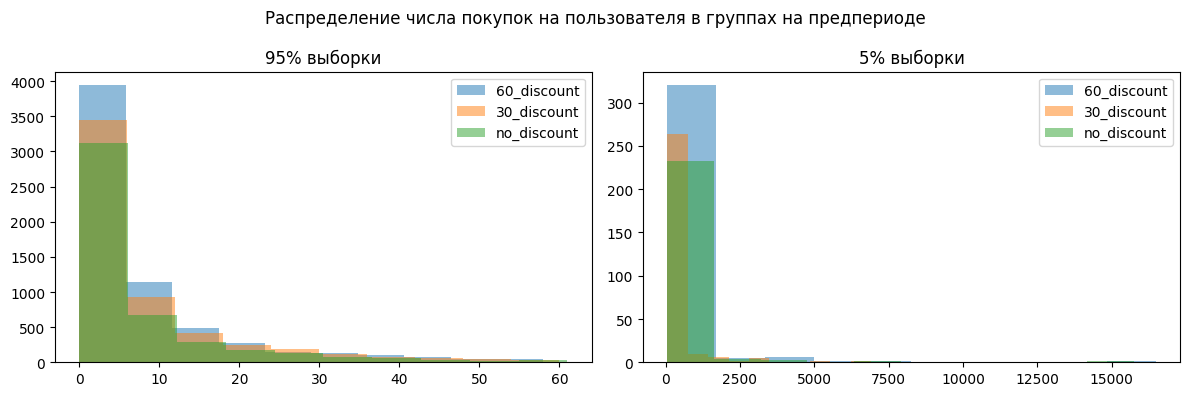

In [382]:
f, ax = plt.subplots(1,2, figsize=(12, 4))
for a in groups:
    t = users_exposure[users_exposure.experiment_group==a]['buy_pred']
    ax[0].hist(t[t.values<=t.quantile(0.95)], alpha = 0.5, label = a)
    ax[1].hist(t[t.values>t.quantile(0.95)], alpha = 0.5, label = a)
ax[0].set_title('95% выборки')
ax[1].set_title('5% выборки')
ax[0].legend()
ax[1].legend()
f.suptitle('Распределение числа покупок на пользователя в группах на предпериоде')
f.set_tight_layout(True)
plt.show()


- Средние в группах различаются не значимо
- СКО в группе 60_discount почти в 2 раза больше, чем в 30_discount, поэтому будем использовать CUPED

In [361]:
users_exposure_b = add_cuped(users_exposure, groups, 'buy_test', 'buy_pred')
ttest_groups(users_exposure_b, groups, 'cuped')

Среднее 60_discount =  24.958029468670933
Среднее 30_discount =  20.477599179206567
Ttest_indResult(statistic=4.517618710708997, pvalue=6.31091339094981e-06)
Среднее 60_discount =  24.958029468670933
Среднее no_discount =  27.495171563591533
Ttest_indResult(statistic=-0.9657508608473354, pvalue=0.3341890233788244)
Среднее 30_discount =  20.477599179206567
Среднее no_discount =  27.495171563591533
Ttest_indResult(statistic=-2.497280520674399, pvalue=0.012529879124339066)


- Различия между группами 60_discount и 30_discount, no_discount и 30_discount значимы
- Порядок средних не изменился: no_discount > 60_dicount > 30_dicount. Это может объясняться несбалансированностью выборок

Посмотрим более подробно на распределение метрики на тесте

In [363]:
descr(users_exposure, groups, 'buy_test')

60_discount
среднее = 24.958029468670933, СКО = 210.33469272996737, медиана = 4.0, 99% квантиль = 280.27999999999884, 99.9% квантиль = 3569.914000000188
30_discount
среднее = 20.477599179206567, СКО = 129.30315070747048, медиана = 4.0, 99% квантиль = 238.58999999999924, 99.9% квантиль = 2192.1310000000067
no_discount
среднее = 27.495171563591533, СКО = 285.35103619703233, медиана = 4.0, 99% квантиль = 393.72000000000116, 99.9% квантиль = 2396.694000000777


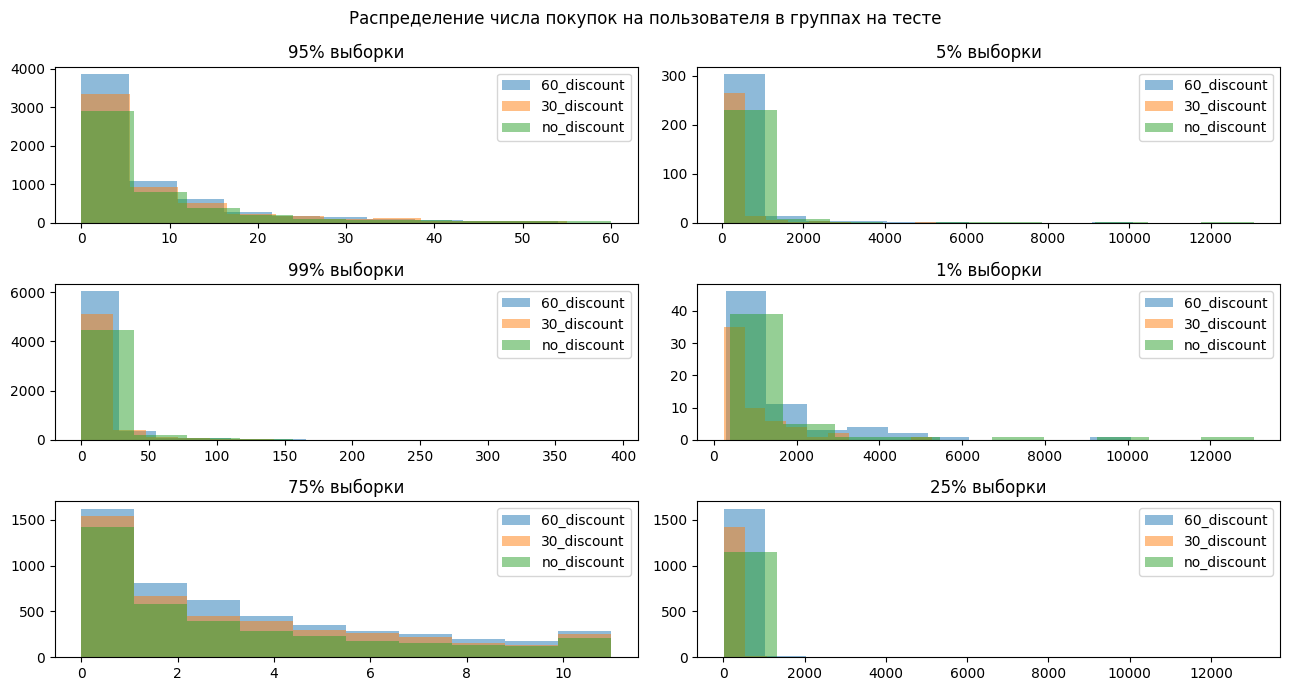

In [377]:
f, ax = plt.subplots(3,2, figsize=(13, 7))
for a in groups:
    t = users_exposure[users_exposure.experiment_group==a]['buy_test']
    ax[0, 0].hist(t[t.values<=t.quantile(0.95)], alpha = 0.5, label = a)
    ax[0, 1].hist(t[t.values>t.quantile(0.95)], alpha = 0.5, label = a)
    ax[1, 0].hist(t[t.values<=t.quantile(0.99)], alpha = 0.5, label = a)
    ax[1, 1].hist(t[t.values>t.quantile(0.99)], alpha = 0.5, label = a)
    ax[2, 0].hist(t[t.values<=t.quantile(0.75)], alpha = 0.5, label = a)
    ax[2, 1].hist(t[t.values>t.quantile(0.75)], alpha = 0.5, label = a)
ax[0, 0].set_title('95% выборки')
ax[0, 1].set_title('5% выборки')
ax[1, 0].set_title('99% выборки')
ax[1, 1].set_title('1% выборки')
ax[2, 0].set_title('75% выборки')
ax[2, 1].set_title('25% выборки')
ax[0, 0].legend()
ax[1, 0].legend()
ax[1, 1].legend()
ax[0, 1].legend()
ax[2, 0].legend()
ax[2, 1].legend()
f.suptitle('Распределение числа покупок на пользователя в группах на тесте')
f.set_tight_layout(True)
plt.show()

На графиках наблюдаем другую картину, чем на результатах проверки гипотезы: визульно число покупок больше в группах со скидками. Однако на графике 1% заметно, что в no_discont есть выбросы.

Поэтому далее проверим гипотезу на 95% и 75% выборки, отсечку сделаем по предпериоду.

In [383]:
users_exposure_95 = users_exposure[users_exposure.buy_pred < users_exposure.buy_pred.quantile(0.95)]
users_exposure_75 = users_exposure[users_exposure.buy_pred < users_exposure.buy_pred.quantile(0.75)]

In [391]:
print('95%')
print('Выборочные статистики на предпериоде:')
descr(users_exposure_95, groups, 'buy_pred')
print('')
print('ВЫборочные статистики на тесте:')
descr(users_exposure_95, groups, 'buy_test')


95%
Выборочные статистики на предпериоде:
60_discount
среднее = 7.628325508607198, СКО = 10.703142082744176, медиана = 3.0, 75% квантиль = 9.0, 95% квантиль = 32.0, 99% квантиль = 51.0, 99.9% квантиль = 58.0
30_discount
среднее = 7.675193658800216, СКО = 10.689233230549519, медиана = 3.0, 75% квантиль = 10.0, 95% квантиль = 31.0, 99% квантиль = 50.0, 99.9% квантиль = 58.0
no_discount
среднее = 7.065857885615252, СКО = 10.156798652815771, медиана = 3.0, 75% квантиль = 9.0, 95% квантиль = 30.0, 99% квантиль = 49.0, 99.9% квантиль = 59.0

ВЫборочные статистики на тесте:
60_discount
среднее = 8.55962441314554, СКО = 19.608600841671652, медиана = 4.0, 75% квантиль = 10.0, 95% квантиль = 30.0, 99% квантиль = 68.10999999999967, 99.9% квантиль = 168.49900000000707
30_discount
среднее = 8.500270221581697, СКО = 16.476780001148477, медиана = 4.0, 75% квантиль = 10.0, 95% квантиль = 33.0, 99% квантиль = 65.0, 99.9% квантиль = 192.9500000000371
no_discount
среднее = 9.035311958405545, СКО = 35.061

Для 95% видим следующее:
- на предпериоде в группах не наблдается значительных различий: ни в средних, ни в СКО
- однако на тесте в группе no_discount появляются выбросы (судя по 99% и 99.9%), при этом в среднем в 60_discount и 30_discount значения выше (судя по медианам, 75%, 95%)

In [392]:
print('75%')
print('Выборочные статистики на предпериоде:')
descr(users_exposure_75, groups, 'buy_pred')
print('')
print('ВЫборочные статистики на тесте:')
descr(users_exposure_75, groups, 'buy_test')

75%
Выборочные статистики на предпериоде:
60_discount
среднее = 2.972972972972973, СКО = 2.8568276581522682, медиана = 2.0, 75% квантиль = 5.0, 95% квантиль = 9.0, 99% квантиль = 10.0, 99.9% квантиль = 10.0
30_discount
среднее = 2.8952671040299904, СКО = 2.8264454873846607, медиана = 2.0, 75% квантиль = 5.0, 95% квантиль = 9.0, 99% квантиль = 10.0, 99.9% квантиль = 10.0
no_discount
среднее = 2.7873626373626372, СКО = 2.8153496491499213, медиана = 2.0, 75% квантиль = 4.0, 95% квантиль = 9.0, 99% квантиль = 10.0, 99.9% квантиль = 10.0

ВЫборочные статистики на тесте:
60_discount
среднее = 5.075030254134732, СКО = 9.97671374636022, медиана = 3.0, 75% квантиль = 6.0, 95% квантиль = 16.0, 99% квантиль = 36.0, 99.9% квантиль = 104.08600000000115
30_discount
среднее = 4.7671040299906275, СКО = 9.801839065994342, медиана = 2.0, 75% квантиль = 6.0, 95% квантиль = 15.649999999999636, 99% квантиль = 34.32999999999993, 99.9% квантиль = 100.46600000000035
no_discount
среднее = 5.066483516483516, СК

Для 75% наблюдается то же самое

Попробуем выбрать порог отсечения по результам теста

In [396]:
users_exposure_95 = users_exposure[users_exposure.buy_test< users_exposure.buy_test.quantile(0.95)]
users_exposure_75 = users_exposure[users_exposure.buy_test < users_exposure.buy_test.quantile(0.75)]

In [399]:
ttest_groups(users_exposure_95, groups, 'buy_test')

Среднее 60_discount =  7.5915625
Среднее 30_discount =  7.657065706570657
Ttest_indResult(statistic=-0.36012853315845267, pvalue=0.7187573788429424)
Среднее 60_discount =  7.5915625
Среднее no_discount =  7.14620899413426
Ttest_indResult(statistic=2.357752914858674, pvalue=0.018403333358985596)
Среднее 30_discount =  7.657065706570657
Среднее no_discount =  7.14620899413426
Ttest_indResult(statistic=2.5744183217628804, pvalue=0.010054912993455829)


Получили, что если исключить выбросы на тесте, средние групп со скидкой значимо больше группы без скидки.

Однако это не совсем правильный подход (тк делим по результатам теста) и остается не понятным, откуда появились выбросы в группе no_discount. Поэтому попробуем разделить пользователей по их типам

##### **Сегментация по типам**

In [403]:
df_segment.columns = ['user_id_x', 'experiment_group', 'user_type', 'registration_time']

In [404]:
df_users_seg = df_users.merge(df_segment[['user_id_x', 'user_type']], on='user_id_x', how='left')

In [409]:
segments = df_users_seg['user_type'].unique()

In [415]:
def descr_s(d, groups, col):
    for a in groups:
        print(a)
        t = d[d.user_type==a][col]
        print(f'количество = {t.count()}, среднее = {t.mean()}, СКО = {t.std()}, медиана = {t.median()}, 75% квантиль = {t.quantile(0.75)}, 95% квантиль = {t.quantile(0.95)}, 99% квантиль = {t.quantile(0.99)}, 99.9% квантиль = {t.quantile(0.999)}')

In [416]:
descr_s(df_users_seg, segments, 'buy_pred')

Company
количество = 35493, среднее = 19.34327895641394, СКО = 229.42296167190412, медиана = 4.0, 75% квантиль = 12.0, 95% квантиль = 54.0, 99% квантиль = 213.1600000000035, 99.9% квантиль = 1598.6680000000342
Private
количество = 263033, среднее = 6.120167431462972, СКО = 42.47516354515001, медиана = 2.0, 75% квантиль = 5.0, 95% квантиль = 22.0, 99% квантиль = 64.0, 99.9% квантиль = 244.9680000000517
Shop
количество = 9507, среднее = 223.8386452087935, СКО = 1391.1304114413736, медиана = 23.0, 75% квантиль = 90.0, 95% квантиль = 866.3999999999978, 99% квантиль = 3843.040000000008, 99.9% квантиль = 10338.282000000121


Очевидно, значения сильно различаются для разных групп. Поэтому далее проведем ttest для пользователей, прошедших верификацию, в зависимости от типа.

In [418]:
users_exposure_seg = users_exposure.merge(df_segment[['user_id_x', 'user_type']], on='user_id_x', how='left')

In [421]:
users_exposure_private = users_exposure_seg[users_exposure_seg.user_type == 'Private']
users_exposure_shop = users_exposure_seg[users_exposure_seg.user_type == 'Shop']
users_exposure_comp = users_exposure_seg[users_exposure_seg.user_type == 'Company']

**Физ лица:**

In [429]:
# объем выборки
users_exposure_private.shape

(19057, 8)

In [425]:
users_exposure_private_b = add_cuped(users_exposure_private, groups, 'buy_test', 'buy_pred')
ttest_groups(users_exposure_private_b, groups, 'cuped')

Среднее 60_discount =  9.141335740072202
Среднее 30_discount =  9.023039526527162
Ttest_indResult(statistic=0.3646854936563533, pvalue=0.7153536978645294)
Среднее 60_discount =  9.141335740072202
Среднее no_discount =  8.12888436067244
Ttest_indResult(statistic=2.988798423637143, pvalue=0.0028079615086275297)
Среднее 30_discount =  9.023039526527162
Среднее no_discount =  8.12888436067244
Ttest_indResult(statistic=3.058309689699225, pvalue=0.0022326939630737033)


В группах со скидками покупок значимо больше.

**Компании:**

In [431]:
# объем выборки
users_exposure_comp.shape

(2551, 8)

In [435]:
descr(users_exposure_comp, groups, 'buy_pred')

60_discount
среднее = 32.995, СКО = 181.88998717437107, медиана = 7.0, 75% квантиль = 20.25, 95% квантиль = 89.14999999999986, 99% квантиль = 395.2199999999998, 99.9% квантиль = 3030.4340000000857, кол-во = 800
30_discount
среднее = 24.278709677419354, СКО = 89.04509062103084, медиана = 8.0, 75% квантиль = 20.5, 95% квантиль = 88.0, 99% квантиль = 215.51999999999998, 99.9% квантиль = 1110.3800000001274, кол-во = 775
no_discount
среднее = 31.288709677419355, СКО = 174.92123923910165, медиана = 7.0, 75% квантиль = 19.0, 95% квантиль = 96.19999999999982, 99% квантиль = 421.5699999999947, 99.9% квантиль = 2062.622000000262, кол-во = 620


In [439]:
ttest_groups(users_exposure_comp, groups, 'buy_pred')

Среднее 60_discount =  32.995
Среднее 30_discount =  24.278709677419354
Ttest_indResult(statistic=1.2018077938960423, pvalue=0.22961890533668378)
Среднее 60_discount =  32.995
Среднее no_discount =  31.288709677419355
Ttest_indResult(statistic=0.1782726125203548, pvalue=0.858534350841686)
Среднее 30_discount =  24.278709677419354
Среднее no_discount =  31.288709677419355
Ttest_indResult(statistic=-0.9696531005619268, pvalue=0.33238776211967547)


In [432]:
users_exposure_comp_b = add_cuped(users_exposure_comp, groups, 'buy_test', 'buy_pred')
ttest_groups(users_exposure_comp_b, groups, 'cuped')

Среднее 60_discount =  24.57375
Среднее 30_discount =  19.224516129032256
Ttest_indResult(statistic=3.0305664730480864, pvalue=0.002480779310432438)
Среднее 60_discount =  24.57375
Среднее no_discount =  25.116129032258065
Ttest_indResult(statistic=-0.1738725581431143, pvalue=0.8619904374826142)
Среднее 30_discount =  19.224516129032256
Среднее no_discount =  25.116129032258065
Ttest_indResult(statistic=-1.7066662327234987, pvalue=0.08810698059648815)


В группе 60_discount значимо больше покупок, чем в 30_discount. При этом соотношение средних no_discount > 60_discount > 30_discount

**Магазины:**

In [436]:
# объем выборки
users_exposure_shop.shape

(1050, 8)

In [437]:
descr(users_exposure_shop, groups, 'buy_pred')

60_discount
среднее = 299.155672823219, СКО = 1165.9569449147693, медиана = 26.0, 75% квантиль = 112.0, 95% квантиль = 1255.1, 99% квантиль = 5113.299999999975, 99.9% квантиль = 12991.88800000013, кол-во = 379
30_discount
среднее = 207.01461988304092, СКО = 664.681351405218, медиана = 27.0, 75% квантиль = 88.75, 95% квантиль = 994.1999999999987, 99% квантиль = 3147.2599999999998, 99.9% квантиль = 6424.439000000069, кол-во = 342
no_discount
среднее = 240.01246105919003, СКО = 1058.5356423353144, медиана = 26.0, 75% квантиль = 105.0, 95% квантиль = 778.0, 99% квантиль = 3409.600000000003, 99.9% квантиль = 12884.880000000569, кол-во = 321


In [440]:
users_exposure_shop_b = add_cuped(users_exposure_shop, groups, 'buy_test', 'buy_pred')
ttest_groups(users_exposure_shop_b, groups, 'cuped')

Среднее 60_discount =  256.9683377308707
Среднее 30_discount =  181.77192982456137
Ttest_indResult(statistic=4.814193249747619, pvalue=1.8023954671426588e-06)
Среднее 60_discount =  256.9683377308707
Среднее no_discount =  268.9501557632399
Ttest_indResult(statistic=-0.2889024404374155, pvalue=0.7727418156146303)
Среднее 30_discount =  181.77192982456137
Среднее no_discount =  268.9501557632399
Ttest_indResult(statistic=-2.003701786422228, pvalue=0.045509653988056085)


В группе 60_discount значимо больше покупок, чем в 30_discount. При этом соотношение средних no_discount > 60_discount > 30_discount

Результаты для компаний и магазинов нельзя объяснить несбалансированностью выборок, тк на предпериоде больше выбросов содержалось в группе 60_discount.

Поэтому далее посмотрим, какое количество пользователей в каждой из групп пользуется услугами 3 типа в вертикали 1.